# Section 1 - Node Classification via GCN

Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_rate=0.001, step_size=50, gamma=0.5
Accuracy for current hyperparameters: 0.7302631578947368, Loss: 0.37155163288116455
Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_rate=0.001, step_size=50, gamma=0.9
Accuracy for current hyperparameters: 0.6118421052631579, Loss: 0.2181868702173233
Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_rate=0.001, step_size=100, gamma=0.5
Accuracy for current hyperparameters: 0.6842105263157895, Loss: 0.2246384471654892
Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_rate=0.001, step_size=100, gamma=0.9
Accuracy for current hyperparameters: 0.6710526315789473, Loss: 0.2064412534236908
Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_rate=0.005, step_size=50, gamma=0.5
Accuracy for current hyperparameters: 0.5723684210526315, Loss: 0.0579407624900341
Testing hyperparameters: hidden_channels=64, dropout=0.3, learning_

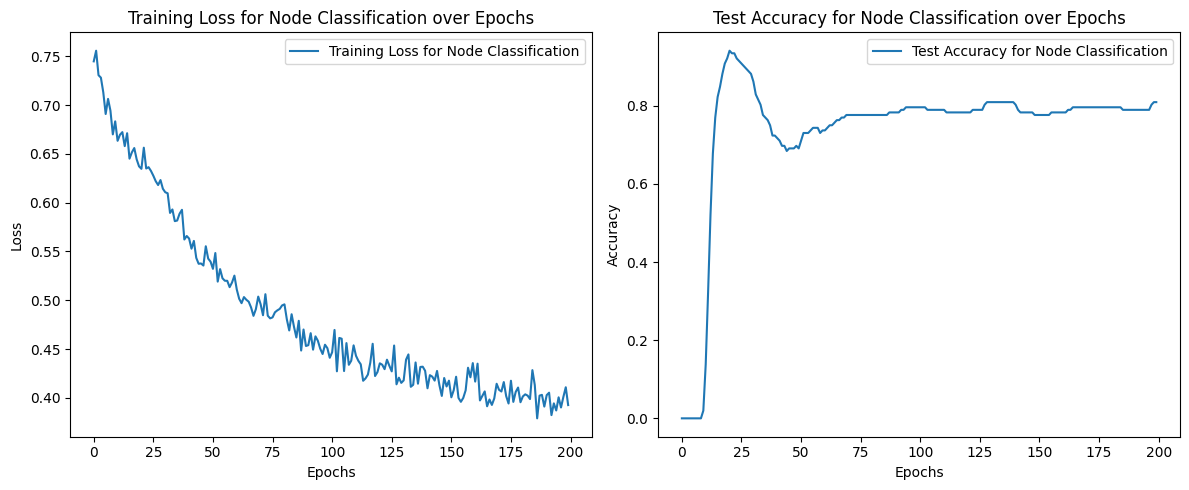

In [168]:
############################# GCN NODE CLASSIFICATION AND PREDICTION SECTION
########################### (loss: the loss of current interations)
############################# (accuracy: rate of properly classifying race per node)

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/home/arifai/hussain/Race_pathways_signatures_meta_short.csv'
data = pd.read_csv(file_path)

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Drop non-numeric columns (assuming the first 3 columns are metadata)
gene_expression = data.iloc[:, 1:-1]  # Exclude the label column

# Handle missing values (e.g., fill with the mean of the column)
gene_expression = gene_expression.apply(pd.to_numeric, errors='coerce')
gene_expression = gene_expression.fillna(gene_expression.mean())

# Convert to numpy array
gene_expression = gene_expression.values

# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7 
edges = np.where(np.abs(correlation_matrix) > threshold)
edges = np.array(edges)  # Convert to a single numpy array
edge_index = torch.tensor(edges, dtype=torch.long)

# Create node features (gene expression levels)
x = torch.tensor(gene_expression, dtype=torch.float)

# Use actual labels from the dataset
y = torch.tensor(data['label'].values, dtype=torch.long)

# Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

# Manually split the data into training and test sets
num_train = 1000
num_test = 152

# Create masks for training and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
test_mask[num_train:num_train + num_test] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize model, loss, and optimizer
model = GCNNodeClassification(num_node_features=data.num_features, hidden_channels=128)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop for node classification
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

# Evaluation for node classification
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Train the model
for epoch in range(200):
    loss = train()
    acc = test()
    train_losses.append(loss)
    test_accuracies.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {acc}')

# Save the model
torch.save(model.state_dict(), '/home/arifai/hussain/gcn_node_classification_model.pth')

# Load the model
model = GCNNodeClassification(num_node_features=data.num_features, hidden_channels=256)
model.load_state_dict(torch.load('/home/arifai/hussain/gcn_node_classification_model.pth'))
model.eval()

# Print the final test accuracy
final_test_accuracy = test()
print(f'Final Test Accuracy: {final_test_accuracy}')

# Plotting the results for node classification
epochs = range(200)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Node Classification
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss for Node Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Node Classification over Epochs')
plt.legend()

# Plot Test Accuracy for Node Classification
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy for Node Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Node Classification over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('/home/arifai/hussain/node_classification_loss_accuracy.png')
plt.show()


(120, 120)
(2, 187)


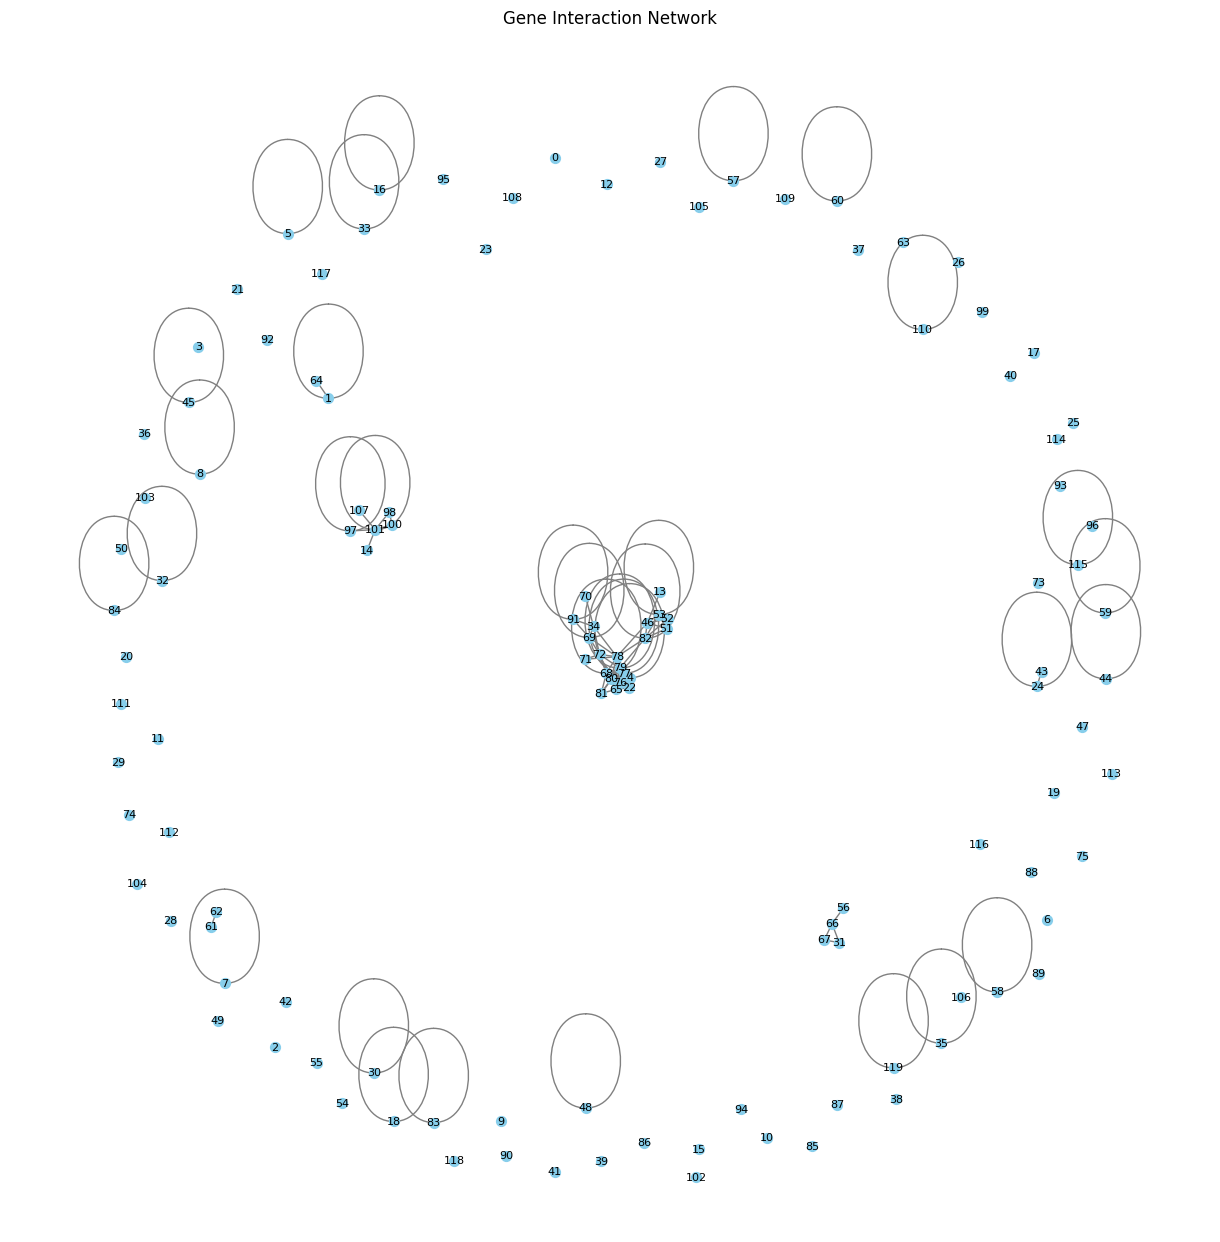

In [183]:
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.utils import to_networkx

# Use the preprocessed data from Section 1
# Compute correlation matrix
correlation_matrix = np.corrcoef(gene_expression, rowvar=False)

print(np.shape(correlation_matrix))

# Define a threshold for creating edges
threshold = 0.7
edges = np.where((np.abs(correlation_matrix) > threshold) & (np.abs(correlation_matrix != 1)))
edge_index = torch.tensor(edges, dtype=torch.long)

print(np.shape(edges))

# Create a NetworkX graph
G = nx.Graph()

# Add nodes (genes)
num_genes = correlation_matrix.shape[0]
G.add_nodes_from(range(num_genes))

# Add edges based on the correlation threshold
for i in range(edges[0].shape[0]):
    G.add_edge(edges[0][i], edges[1][i])

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', font_size=8)
plt.title('Gene Interaction Network')
plt.show()


# Section 2 - Link Prediction via GCN (SPLIT BY RACE)

### African American Link Prediction

Total number of positive training edges (AA): 244
Total number of negative training edges (AA): 244
Total number of positive testing edges (AA): 27
Total number of negative testing edges (AA): 27
Epoch 0, Link Prediction Loss (AA): 0.6836774349212646, Link Prediction Accuracy (AA): 0.5
Epoch 10, Link Prediction Loss (AA): 0.5651465654373169, Link Prediction Accuracy (AA): 0.5185185185185185
Epoch 20, Link Prediction Loss (AA): 0.43663156032562256, Link Prediction Accuracy (AA): 0.5185185185185185
Epoch 30, Link Prediction Loss (AA): 0.37141937017440796, Link Prediction Accuracy (AA): 0.5740740740740741
Epoch 40, Link Prediction Loss (AA): 0.3076383173465729, Link Prediction Accuracy (AA): 0.7222222222222222
Epoch 50, Link Prediction Loss (AA): 0.24116455018520355, Link Prediction Accuracy (AA): 0.7407407407407407
Epoch 60, Link Prediction Loss (AA): 0.17454075813293457, Link Prediction Accuracy (AA): 0.8333333333333334
Epoch 70, Link Prediction Loss (AA): 0.14907963573932648, Link Pred

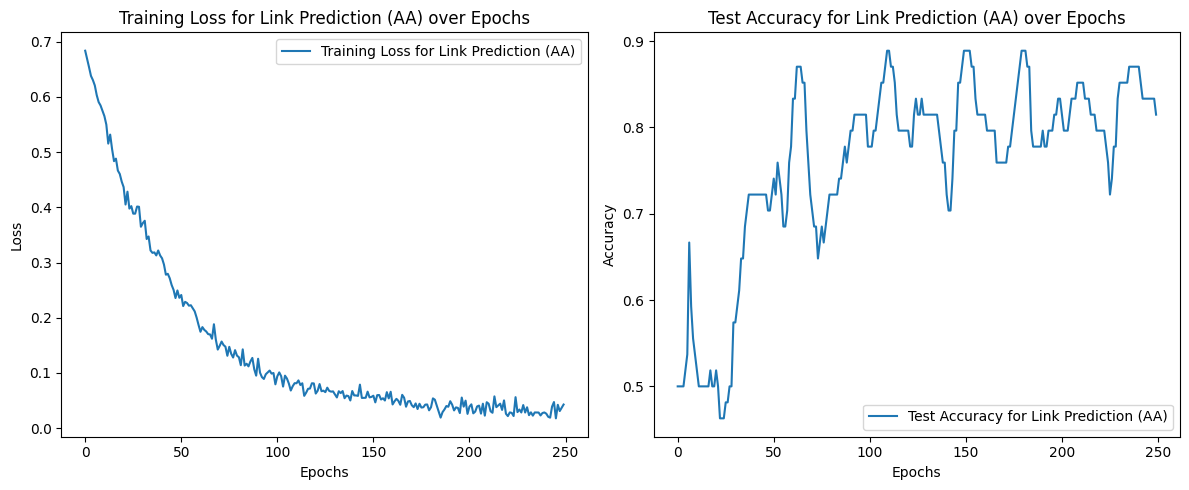

In [160]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Load the dataset
file_path = '/home/arifai/hussain/Race_pathways_signatures_meta_short.csv'
data = pd.read_csv(file_path)

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Filter data for African American individuals
data_aa = data[data['Race'] == "African American"]

# Drop non-numeric columns (race)
gene_expression_aa = data_aa.iloc[:, 1:-2]  # Exclude the race and label columns

# Handle missing values (e.g., fill with the mean of the column)
gene_expression_aa = gene_expression_aa.apply(pd.to_numeric, errors='coerce')
gene_expression_aa = gene_expression_aa.fillna(gene_expression_aa.mean())

# Convert to numpy array
gene_expression_aa = gene_expression_aa.values

# Compute correlation matrix
correlation_matrix_aa = np.corrcoef(gene_expression_aa, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges_aa = np.where(np.abs(correlation_matrix_aa) > threshold)

# Convert the list of numpy arrays to a single numpy array
edges_aa = np.array(edges_aa)

# Create edge_index tensor
edge_index_aa = torch.tensor(edges_aa, dtype=torch.long)

# Create node features (gene expression levels)
x_aa = torch.tensor(gene_expression_aa, dtype=torch.float)

# Use actual labels from the dataset
y_aa = torch.tensor(data_aa['label'].values, dtype=torch.long)

# Create PyG data object
data_aa = Data(x=x_aa, edge_index=edge_index_aa, y=y_aa)

# Split edge set for training and testing
u_aa, v_aa = edge_index_aa
eids_aa = np.arange(edge_index_aa.size(1))
eids_aa = np.random.permutation(eids_aa)
test_size_aa = int(len(eids_aa) * 0.1)
train_size_aa = len(eids_aa) - test_size_aa
test_pos_u_aa, test_pos_v_aa = u_aa[eids_aa[:test_size_aa]], v_aa[eids_aa[:test_size_aa]]
train_pos_u_aa, train_pos_v_aa = u_aa[eids_aa[test_size_aa:]], v_aa[eids_aa[test_size_aa:]]

# Find all negative edges and split them for training and testing
adj_aa = sp.coo_matrix((np.ones(len(u_aa)), (u_aa.numpy(), v_aa.numpy())), shape=(data_aa.num_nodes, data_aa.num_nodes))
adj_neg_aa = 1 - adj_aa.todense() - np.eye(data_aa.num_nodes)
neg_u_aa, neg_v_aa = np.where(adj_neg_aa != 0)

neg_eids_aa = np.random.choice(len(neg_u_aa), len(eids_aa))
test_neg_u_aa, test_neg_v_aa = neg_u_aa[neg_eids_aa[:test_size_aa]], neg_v_aa[neg_eids_aa[:test_size_aa]]
train_neg_u_aa, train_neg_v_aa = neg_u_aa[neg_eids_aa[test_size_aa:]], neg_v_aa[neg_eids_aa[test_size_aa:]]

# Combine positive and negative edges for training
train_edge_index_aa = torch.tensor(np.vstack((np.hstack((train_pos_u_aa, train_neg_u_aa)), np.hstack((train_pos_v_aa, train_neg_v_aa)))), dtype=torch.long)
train_edge_labels_aa = torch.cat([torch.ones(train_size_aa), torch.zeros(train_size_aa)], dim=0).unsqueeze(1)

# Combine positive and negative edges for testing
test_edge_index_aa = torch.tensor(np.vstack((np.hstack((test_pos_u_aa, test_neg_u_aa)), np.hstack((test_pos_v_aa, test_neg_v_aa)))), dtype=torch.long)
test_edge_labels_aa = torch.cat([torch.ones(test_size_aa), torch.zeros(test_size_aa)], dim=0).unsqueeze(1)

# Print the total number of positive and negative edges
train_size_pos_aa = len(train_pos_u_aa)
train_size_neg_aa = len(train_neg_u_aa)
test_size_pos_aa = len(test_pos_u_aa)
test_size_neg_aa = len(test_neg_u_aa)

print(f'Total number of positive training edges (AA): {train_size_pos_aa}')
print(f'Total number of negative training edges (AA): {train_size_neg_aa}')
print(f'Total number of positive testing edges (AA): {test_size_pos_aa}')
print(f'Total number of negative testing edges (AA): {test_size_neg_aa}')

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

# Define MLP model for link prediction
class MLPLinkPrediction(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(MLPLinkPrediction, self).__init__()
        self.gcn = GCNNodeClassification(num_node_features, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, edge_index_pos, edge_index_neg):
        x = self.gcn(x, edge_index)
        pos_edge_embeddings = torch.cat([x[edge_index_pos[0]], x[edge_index_pos[1]]], dim=1)
        neg_edge_embeddings = torch.cat([x[edge_index_neg[0]], x[edge_index_neg[1]]], dim=1)
        edge_embeddings = torch.cat([pos_edge_embeddings, neg_edge_embeddings], dim=0)
        x = F.relu(self.fc1(edge_embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer for link prediction
model_link_pred_aa = MLPLinkPrediction(num_node_features=data_aa.num_features, hidden_channels=64)
criterion_link_pred_aa = torch.nn.BCEWithLogitsLoss()
optimizer_link_pred_aa = torch.optim.Adam(model_link_pred_aa.parameters(), lr=0.0015)

# Training loop for link prediction
def train_link_prediction_aa():
    model_link_pred_aa.train()
    optimizer_link_pred_aa.zero_grad()
    out = model_link_pred_aa(data_aa.x, data_aa.edge_index, train_edge_index_aa[:, :train_size_pos_aa], train_edge_index_aa[:, train_size_pos_aa:])
    loss = criterion_link_pred_aa(out, train_edge_labels_aa)
    loss.backward()
    optimizer_link_pred_aa.step()
    return loss.item()

# Evaluation for link prediction
def test_link_prediction_aa():
    model_link_pred_aa.eval()
    with torch.no_grad():
        out = model_link_pred_aa(data_aa.x, data_aa.edge_index, test_edge_index_aa[:, :test_size_pos_aa], test_edge_index_aa[:, test_size_pos_aa:])
        pred = torch.sigmoid(out)
        pred_labels = (pred > 0.5).float()
        correct = (pred_labels == test_edge_labels_aa).sum()
        acc = int(correct) / len(test_edge_labels_aa)
        return acc, pred

# Store loss and accuracy for plotting
train_losses_link_pred_aa = []
test_accuracies_link_pred_aa = []

# Train the link prediction model
for epoch in range(250):
    loss = train_link_prediction_aa()
    acc, _ = test_link_prediction_aa()
    train_losses_link_pred_aa.append(loss)
    test_accuracies_link_pred_aa.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Link Prediction Loss (AA): {loss}, Link Prediction Accuracy (AA): {acc}')

# Save the link prediction model
torch.save(model_link_pred_aa.state_dict(), '/home/arifai/hussain/mlp_link_prediction_model_aa.pth')

# Load the link prediction model
model_link_pred_aa = MLPLinkPrediction(num_node_features=data_aa.num_features, hidden_channels=64)
model_link_pred_aa.load_state_dict(torch.load('/home/arifai/hussain/mlp_link_prediction_model_aa.pth'))
model_link_pred_aa.eval()

# Print the final test accuracy for link prediction and get confidence scores
final_test_accuracy_link_pred_aa, confidence_scores_aa = test_link_prediction_aa()
print(f'Final Test Accuracy for Link Prediction (AA): {final_test_accuracy_link_pred_aa}')

# Plotting the results for link prediction
epochs = range(250)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Link Prediction
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_link_pred_aa, label='Training Loss for Link Prediction (AA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Link Prediction (AA) over Epochs')
plt.legend()

# Plot Test Accuracy for Link Prediction
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies_link_pred_aa, label='Test Accuracy for Link Prediction (AA)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Link Prediction (AA) over Epochs')
plt.legend()    

plt.tight_layout()
plt.savefig('/home/arifai/hussain/link_prediction_loss_accuracy_aa.png')
plt.show()

### White (Non-Hispanic) Link Prediction

Total number of positive training edges (White): 248
Total number of negative training edges (White): 248
Total number of positive testing edges (White): 27
Total number of negative testing edges (White): 27
Epoch 0, Link Prediction Loss (White): 0.7040421366691589, Link Prediction Accuracy (White): 0.5185185185185185
Epoch 10, Link Prediction Loss (White): 0.5134629607200623, Link Prediction Accuracy (White): 0.5
Epoch 20, Link Prediction Loss (White): 0.3699585199356079, Link Prediction Accuracy (White): 0.5
Epoch 30, Link Prediction Loss (White): 0.30498555302619934, Link Prediction Accuracy (White): 0.6666666666666666
Epoch 40, Link Prediction Loss (White): 0.2584274113178253, Link Prediction Accuracy (White): 0.7222222222222222
Epoch 50, Link Prediction Loss (White): 0.20984388887882233, Link Prediction Accuracy (White): 0.6851851851851852
Epoch 60, Link Prediction Loss (White): 0.1581050157546997, Link Prediction Accuracy (White): 0.7407407407407407
Epoch 70, Link Prediction Loss

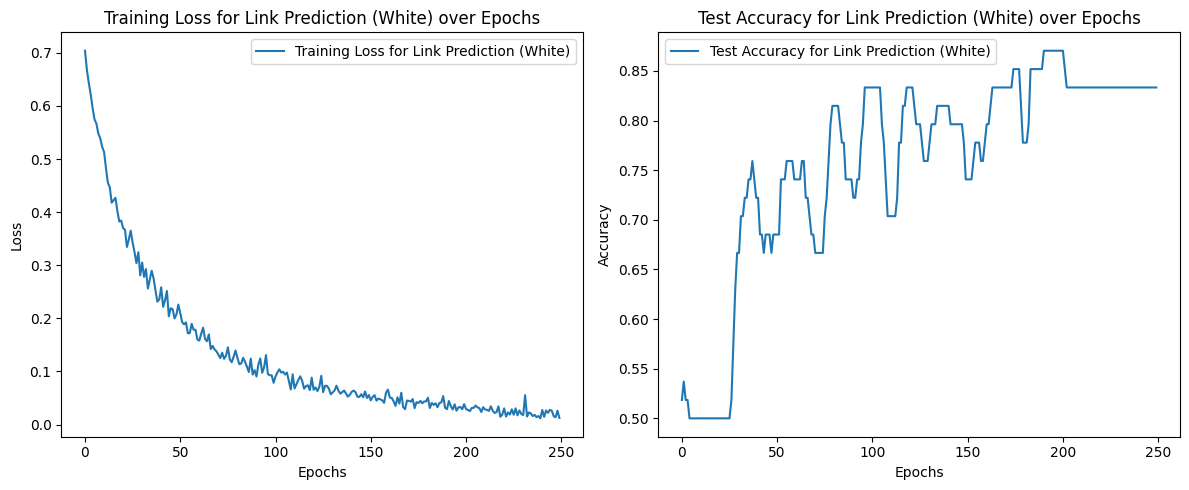

In [181]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Load the dataset
file_path = '/home/arifai/hussain/Race_pathways_signatures_meta_short.csv'
data = pd.read_csv(file_path)

# Remove columns with repeated names
data = data.loc[:, ~data.columns.duplicated()]

# Assign binary labels based on race
data['label'] = data['Race'].apply(lambda x: 0 if x == "White (Non-Hispanic)" else 1 if x == "African American" else np.nan)

# Drop rows with NaN labels (if any)
data = data.dropna(subset=['label'])

# Filter data for White (Non-Hispanic) individuals
data_white = data[data['Race'] == "White (Non-Hispanic)"]

# Drop non-numeric columns (race)
gene_expression_white = data_white.iloc[:, 1:-2]  # Exclude the race and label columns

# Handle missing values (e.g., fill with the mean of the column)
gene_expression_white = gene_expression_white.apply(pd.to_numeric, errors='coerce')
gene_expression_white = gene_expression_white.fillna(gene_expression_white.mean())

# Convert to numpy array
gene_expression_white = gene_expression_white.values

# Compute correlation matrix
correlation_matrix_white = np.corrcoef(gene_expression_white, rowvar=False)

# Define a threshold for creating edges
threshold = 0.7
edges_white = np.where(np.abs(correlation_matrix_white) > threshold)

# Convert the list of numpy arrays to a single numpy array
edges_white = np.array(edges_white)

# Create edge_index tensor
edge_index_white = torch.tensor(edges_white, dtype=torch.long)

# Create node features (gene expression levels)
x_white = torch.tensor(gene_expression_white, dtype=torch.float)

# Use actual labels from the dataset
y_white = torch.tensor(data_white['label'].values, dtype=torch.long)

# Create PyG data object
data_white = Data(x=x_white, edge_index=edge_index_white, y=y_white)

# Split edge set for training and testing
u_white, v_white = edge_index_white
eids_white = np.arange(edge_index_white.size(1))
eids_white = np.random.permutation(eids_white)
test_size_white = int(len(eids_white) * 0.1)
train_size_white = len(eids_white) - test_size_white
test_pos_u_white, test_pos_v_white = u_white[eids_white[:test_size_white]], v_white[eids_white[:test_size_white]]
train_pos_u_white, train_pos_v_white = u_white[eids_white[test_size_white:]], v_white[eids_white[test_size_white:]]

# Find all negative edges and split them for training and testing
adj_white = sp.coo_matrix((np.ones(len(u_white)), (u_white.numpy(), v_white.numpy())), shape=(data_white.num_nodes, data_white.num_nodes))
adj_neg_white = 1 - adj_white.todense() - np.eye(data_white.num_nodes)
neg_u_white, neg_v_white = np.where(adj_neg_white != 0)

neg_eids_white = np.random.choice(len(neg_u_white), len(eids_white))
test_neg_u_white, test_neg_v_white = neg_u_white[neg_eids_white[:test_size_white]], neg_v_white[neg_eids_white[:test_size_white]]
train_neg_u_white, train_neg_v_white = neg_u_white[neg_eids_white[test_size_white:]], neg_v_white[neg_eids_white[test_size_white:]]

# Combine positive and negative edges for training
train_edge_index_white = torch.tensor(np.vstack((np.hstack((train_pos_u_white, train_neg_u_white)), np.hstack((train_pos_v_white, train_neg_v_white)))), dtype=torch.long)
train_edge_labels_white = torch.cat([torch.ones(train_size_white), torch.zeros(train_size_white)], dim=0).unsqueeze(1)

# Combine positive and negative edges for testing
test_edge_index_white = torch.tensor(np.vstack((np.hstack((test_pos_u_white, test_neg_u_white)), np.hstack((test_pos_v_white, test_neg_v_white)))), dtype=torch.long)
test_edge_labels_white = torch.cat([torch.ones(test_size_white), torch.zeros(test_size_white)], dim=0).unsqueeze(1)

# Print the total number of positive and negative edges
train_size_pos_white = len(train_pos_u_white)
train_size_neg_white = len(train_neg_u_white)
test_size_pos_white = len(test_pos_u_white)
test_size_neg_white = len(test_neg_u_white)

print(f'Total number of positive training edges (White): {train_size_pos_white}')
print(f'Total number of negative training edges (White): {train_size_neg_white}')
print(f'Total number of positive testing edges (White): {test_size_pos_white}')
print(f'Total number of negative testing edges (White): {test_size_neg_white}')

# Define GNN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = torch.nn.BatchNorm1d(hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

# Define MLP model for link prediction
class MLPLinkPrediction(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(MLPLinkPrediction, self).__init__()
        self.gcn = GCNNodeClassification(num_node_features, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index, edge_index_pos, edge_index_neg):
        x = self.gcn(x, edge_index)
        pos_edge_embeddings = torch.cat([x[edge_index_pos[0]], x[edge_index_pos[1]]], dim=1)
        neg_edge_embeddings = torch.cat([x[edge_index_neg[0]], x[edge_index_neg[1]]], dim=1)
        edge_embeddings = torch.cat([pos_edge_embeddings, neg_edge_embeddings], dim=0)
        x = F.relu(self.fc1(edge_embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer for link prediction
model_link_pred_white = MLPLinkPrediction(num_node_features=data_white.num_features, hidden_channels=64)
criterion_link_pred_white = torch.nn.BCEWithLogitsLoss()
optimizer_link_pred_white = torch.optim.Adam(model_link_pred_white.parameters(), lr=0.0015)

# Training loop for link prediction
def train_link_prediction_white():
    model_link_pred_white.train()
    optimizer_link_pred_white.zero_grad()
    out = model_link_pred_white(data_white.x, data_white.edge_index, train_edge_index_white[:, :train_size_pos_white], train_edge_index_white[:, train_size_pos_white:])
    loss = criterion_link_pred_white(out, train_edge_labels_white)
    loss.backward()
    optimizer_link_pred_white.step()
    return loss.item()

# Evaluation for link prediction
def test_link_prediction_white():
    model_link_pred_white.eval()
    with torch.no_grad():
        out = model_link_pred_white(data_white.x, data_white.edge_index, test_edge_index_white[:, :test_size_pos_white], test_edge_index_white[:, test_size_pos_white:])
        pred = torch.sigmoid(out)
        pred_labels = (pred > 0.5).float()
        correct = (pred_labels == test_edge_labels_white).sum()
        acc = int(correct) / len(test_edge_labels_white)
        return acc, pred

# Store loss and accuracy for plotting
train_losses_link_pred_white = []
test_accuracies_link_pred_white = []

# Train the link prediction model
for epoch in range(250):
    loss = train_link_prediction_white()
    acc, _ = test_link_prediction_white()
    train_losses_link_pred_white.append(loss)
    test_accuracies_link_pred_white.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Link Prediction Loss (White): {loss}, Link Prediction Accuracy (White): {acc}')

# Save the link prediction model
torch.save(model_link_pred_white.state_dict(), '/home/arifai/hussain/mlp_link_prediction_model_white.pth')

# Load the link prediction model
model_link_pred_white = MLPLinkPrediction(num_node_features=data_white.num_features, hidden_channels=64)
model_link_pred_white.load_state_dict(torch.load('/home/arifai/hussain/mlp_link_prediction_model_white.pth'))
model_link_pred_white.eval()

# Print the final test accuracy for link prediction and get confidence scores
final_test_accuracy_link_pred_white, confidence_scores_white = test_link_prediction_white()
print(f'Final Test Accuracy for Link Prediction (White): {final_test_accuracy_link_pred_white}')

# Plotting the results for link prediction
epochs = range(250)

plt.figure(figsize=(12, 5))

# Plot Training Loss for Link Prediction
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_link_pred_white, label='Training Loss for Link Prediction (White)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Link Prediction (White) over Epochs')
plt.legend()

# Plot Test Accuracy for Link Prediction
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies_link_pred_white, label='Test Accuracy for Link Prediction (White)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Link Prediction (White) over Epochs')
plt.legend()    

plt.tight_layout()
plt.savefig('/home/arifai/hussain/link_prediction_loss_accuracy_white.png')
plt.show()

### African-Americans High Confidence Interactions

In [182]:
# Get the top 20 interactions with the highest confidence scores for African Americans
confidence_scores_aa = confidence_scores_aa.squeeze()
top_20_indices_aa = np.argsort(confidence_scores_aa)[-20:][::1]
top_20_scores_aa = confidence_scores_aa[top_20_indices_aa]

# Convert test_edge_index_aa to numpy array and make a copy to avoid negative strides issue
test_edge_index_aa_np = test_edge_index_aa.numpy().copy()
top_20_interactions_aa = test_edge_index_aa_np[:, top_20_indices_aa].T

print("Top interactions with the highest confidence scores for African Americans (low to high):")
interaction_count_aa = 0
printed_interactions_aa = set()

for score, interaction in zip(top_20_scores_aa, top_20_interactions_aa):
    interaction_tuple = tuple(interaction)
    reverse_interaction_tuple = tuple(interaction[::-1])
    
    if interaction[0] != interaction[1] and interaction_tuple not in printed_interactions_aa and reverse_interaction_tuple not in printed_interactions_aa:
        interaction_count_aa += 1
        printed_interactions_aa.add(interaction_tuple)
        print(f"{interaction_count_aa}: Interaction {interaction} with confidence score {score}")

Top interactions with the highest confidence scores for African Americans (low to high):
1: Interaction [82 53] with confidence score 0.9961584210395813
2: Interaction [46 51] with confidence score 0.9970948696136475
3: Interaction [53 46] with confidence score 0.997925877571106
4: Interaction [61 62] with confidence score 0.9995056390762329
5: Interaction [47 20] with confidence score 0.9996654987335205
6: Interaction [ 98 100] with confidence score 0.9996895790100098
7: Interaction [78 22] with confidence score 0.999805748462677
8: Interaction [71 72] with confidence score 0.9998376369476318
9: Interaction [68  4] with confidence score 0.9999260902404785
10: Interaction [77 68] with confidence score 0.9999387264251709
11: Interaction [77 80] with confidence score 0.9999586343765259
12: Interaction [79 68] with confidence score 0.9999608993530273
13: Interaction [78 80] with confidence score 0.9999812841415405


### White (Non-Hispanic) High Confidence Interactions

In [163]:
# Get the top 20 interactions with the highest confidence scores for Whites
confidence_scores_white = confidence_scores_white.squeeze()
top_20_indices_white = np.argsort(confidence_scores_white)[-20:][::1]
top_20_scores_white = confidence_scores_white[top_20_indices_white]

# Convert test_edge_index_white to numpy array and make a copy to avoid negative strides issue
test_edge_index_white_np = test_edge_index_white.numpy().copy()
top_20_interactions_white = test_edge_index_white_np[:, top_20_indices_white].T

print("Top interactions with the highest confidence scores for Whites (low to high):")
interaction_count_white = 0
printed_interactions_white = set()

for score, interaction in zip(top_20_scores_white, top_20_interactions_white):
    interaction_tuple = tuple(interaction)
    reverse_interaction_tuple = tuple(interaction[::-1])
    
    if interaction[0] != interaction[1] and interaction_tuple not in printed_interactions_white and reverse_interaction_tuple not in printed_interactions_white:
        interaction_count_white += 1
        printed_interactions_white.add(interaction_tuple)
        print(f"{interaction_count_white}: Interaction {interaction} with confidence score {score}")

Top interactions with the highest confidence scores for Whites (low to high):
1: Interaction [101  97] with confidence score 0.9997424483299255
2: Interaction [ 98 101] with confidence score 0.9998074173927307
3: Interaction [34 70] with confidence score 0.9998130202293396
4: Interaction [79 22] with confidence score 0.9998517036437988
5: Interaction [82 78] with confidence score 0.9999043941497803
6: Interaction [77 78] with confidence score 0.9999299049377441
7: Interaction [71 34] with confidence score 0.9999377727508545
8: Interaction [52 53] with confidence score 0.9999469518661499
9: Interaction [46 78] with confidence score 0.999951958656311
10: Interaction [46 82] with confidence score 0.9999622106552124
11: Interaction [34 72] with confidence score 0.9999650716781616
12: Interaction [ 6 69] with confidence score 0.9999687671661377
13: Interaction [34 69] with confidence score 0.9999767541885376
14: Interaction [72 68] with confidence score 0.9999769926071167
15: Interaction [7

# Section 3 - Values of Significance

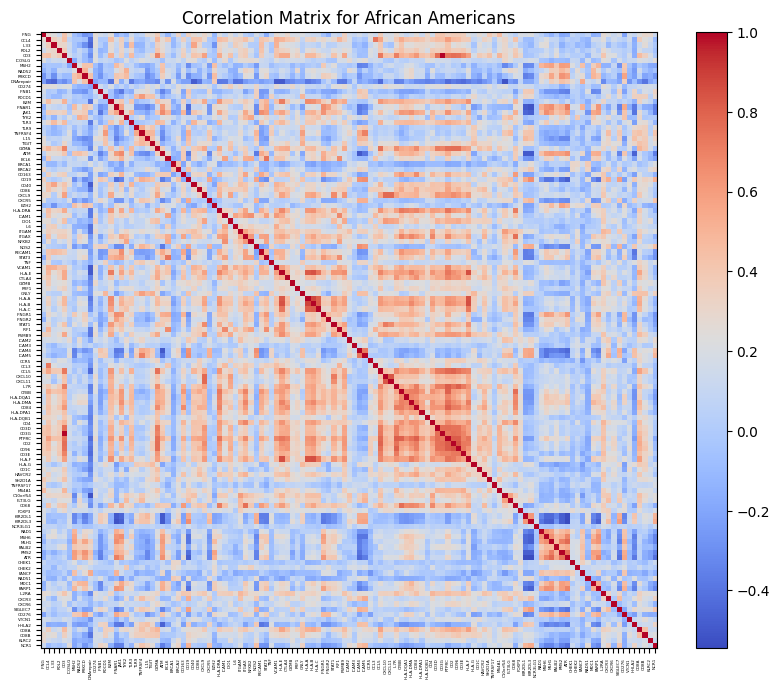

Degree Centrality for African Americans: {'IFNG': 0.0, 'CCL4': 0.00847457627118644, 'IL33': 0.0, 'PDL2': 0.0, 'CD3': 0.059322033898305086, 'ICOSLG': 0.0, 'MSH2': 0.0, 'RAD52': 0.0, 'PRKCD': 0.0, 'DNArepair': 0.0, 'CD274': 0.0, 'IFNB1': 0.0, 'PDCD1': 0.0, 'B2M': 0.00847457627118644, 'IFNAR1': 0.00847457627118644, 'JAK1': 0.0, 'TYK2': 0.0, 'TLR3': 0.0, 'TLR9': 0.0, 'TNFRSF4': 0.0, 'IL15': 0.0, 'TIGIT': 0.0, 'GZMA': 0.0423728813559322, 'ATM': 0.0, 'BCL6': 0.00847457627118644, 'BRCA1': 0.0, 'BRCA2': 0.0, 'CD163': 0.0, 'CD19': 0.0, 'CD40': 0.0, 'CD86': 0.0, 'CXCL9': 0.01694915254237288, 'CXCR5': 0.0, 'EZH2': 0.0, 'HLA-DRA': 0.025423728813559324, 'ICAM1': 0.0, 'IDO1': 0.0, 'IL6': 0.0, 'ITGAM': 0.0, 'ITGAX': 0.00847457627118644, 'NFKB2': 0.0, 'NOS2': 0.0, 'PECAM1': 0.0, 'STAT3': 0.00847457627118644, 'TNF': 0.0, 'VCAM1': 0.0, 'HLA-E': 0.05084745762711865, 'CTLA4': 0.0, 'GZMB': 0.0, 'PRF1': 0.0, 'GNLY': 0.0, 'HLA-A': 0.03389830508474576, 'HLA-B': 0.03389830508474576, 'HLA-C': 0.0338983050847457

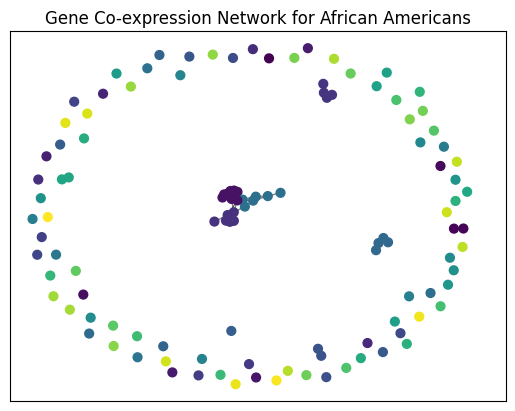

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain

# Load the dataset
file_path = '/home/arifai/hussain/Race_pathways_signatures_meta_short.csv'
df = pd.read_csv(file_path)

# Remove columns with repeated names
df = df.loc[:, ~df.columns.duplicated()]

# Filter data for African Americans
df_aa = df[df['Race'] == "African American"]

# Extract gene names from the original DataFrame
gene_names = df_aa.columns[1:-1]

# Drop non-numeric columns (race)
gene_expression_aa = df_aa.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in gene expression data
gene_expression_aa = gene_expression_aa.dropna()

# Function to visualize the correlation matrix
def visualize_correlation_matrix(correlation_matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(gene_names)), labels=gene_names, rotation=90, fontsize=3)
    plt.yticks(ticks=np.arange(len(gene_names)), labels=gene_names, fontsize=3)
    plt.title(title)
    plt.show()

# Function to perform topological analysis
def topological_analysis(gene_expression, race_name):
    race_corr_matrix = np.corrcoef(gene_expression.values, rowvar=False)
    np.fill_diagonal(race_corr_matrix, 0)
    
    # Construct the gene co-expression network
    G = nx.Graph()
    for gene in gene_names:
        G.add_node(gene)
    for i, gene1 in enumerate(gene_names):
        for j, gene2 in enumerate(gene_names):
            if i < j and abs(race_corr_matrix[i, j]) > 0.7:
                G.add_edge(gene1, gene2, weight=race_corr_matrix[i, j])
    
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    print(f"Degree Centrality for {race_name}:", degree_centrality)
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    print(f"Betweenness Centrality for {race_name}:", betweenness_centrality)
    
    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    print(f"Closeness Centrality for {race_name}:", closeness_centrality)
    
    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G)
    print(f"Eigenvector Centrality for {race_name}:", eigenvector_centrality)
    
    # Clustering coefficient
    clustering_coefficient = nx.clustering(G)
    print(f"Clustering Coefficient for {race_name}:", clustering_coefficient)
    
    # Community detection using the Louvain method
    partition = community_louvain.best_partition(G)
    print(f"Community Detection (Louvain) for {race_name}:", partition)
    
    # Visualize the network with community detection
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Gene Co-expression Network for {race_name}")
    plt.show()

# Perform analysis for African Americans
race_corr_matrix_aa = np.corrcoef(gene_expression_aa.values, rowvar=False)
visualize_correlation_matrix(race_corr_matrix_aa, "Correlation Matrix for African Americans")
topological_analysis(gene_expression_aa, "African Americans")

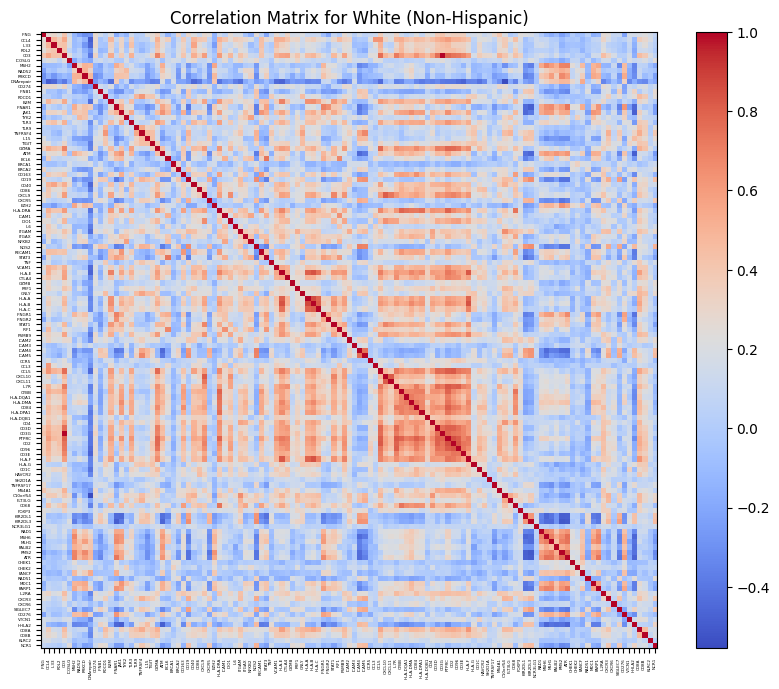

Degree Centrality for White (Non-Hispanic): {'IFNG': 0.0, 'CCL4': 0.0, 'IL33': 0.0, 'PDL2': 0.0, 'CD3': 0.059322033898305086, 'ICOSLG': 0.0, 'MSH2': 0.0, 'RAD52': 0.0, 'PRKCD': 0.0, 'DNArepair': 0.0, 'CD274': 0.0, 'IFNB1': 0.0, 'PDCD1': 0.0, 'B2M': 0.0, 'IFNAR1': 0.00847457627118644, 'JAK1': 0.0, 'TYK2': 0.0, 'TLR3': 0.0, 'TLR9': 0.0, 'TNFRSF4': 0.0, 'IL15': 0.0, 'TIGIT': 0.0, 'GZMA': 0.0423728813559322, 'ATM': 0.0, 'BCL6': 0.00847457627118644, 'BRCA1': 0.0, 'BRCA2': 0.0, 'CD163': 0.0, 'CD19': 0.0, 'CD40': 0.0, 'CD86': 0.0, 'CXCL9': 0.01694915254237288, 'CXCR5': 0.0, 'EZH2': 0.0, 'HLA-DRA': 0.059322033898305086, 'ICAM1': 0.0, 'IDO1': 0.0, 'IL6': 0.0, 'ITGAM': 0.0, 'ITGAX': 0.0, 'NFKB2': 0.0, 'NOS2': 0.0, 'PECAM1': 0.0, 'STAT3': 0.00847457627118644, 'TNF': 0.0, 'VCAM1': 0.0, 'HLA-E': 0.0423728813559322, 'CTLA4': 0.0, 'GZMB': 0.0, 'PRF1': 0.0, 'GNLY': 0.0, 'HLA-A': 0.03389830508474576, 'HLA-B': 0.03389830508474576, 'HLA-C': 0.025423728813559324, 'IFNGR1': 0.0, 'IFNGR2': 0.0, 'STAT1': 0.0

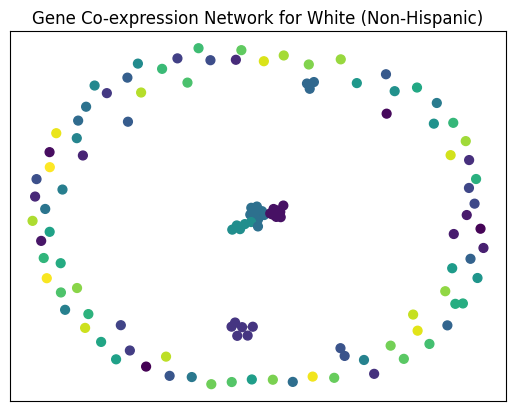

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain

# Load the dataset
file_path = '/home/arifai/hussain/Race_pathways_signatures_meta_short.csv'
df = pd.read_csv(file_path)

# Remove columns with repeated names
df = df.loc[:, ~df.columns.duplicated()]

# Filter data for White (Non-Hispanic)
df_wh = df[df['Race'] == "White (Non-Hispanic)"]

# Extract gene names from the original DataFrame
gene_names = df_wh.columns[1:-1]

# Drop non-numeric columns (race)
gene_expression_wh = df_wh.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in gene expression data
gene_expression_wh = gene_expression_wh.dropna()

# Function to visualize the correlation matrix
def visualize_correlation_matrix(correlation_matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(gene_names)), labels=gene_names, rotation=90, fontsize=3)
    plt.yticks(ticks=np.arange(len(gene_names)), labels=gene_names, fontsize=3)
    plt.title(title)
    plt.show()

# Function to perform topological analysis
def topological_analysis(gene_expression, race_name):
    race_corr_matrix = np.corrcoef(gene_expression.values, rowvar=False)
    np.fill_diagonal(race_corr_matrix, 0)
    
    # Construct the gene co-expression network
    G = nx.Graph()
    for gene in gene_names:
        G.add_node(gene)
    for i, gene1 in enumerate(gene_names):
        for j, gene2 in enumerate(gene_names):
            if i < j and abs(race_corr_matrix[i, j]) > 0.7:
                G.add_edge(gene1, gene2, weight=race_corr_matrix[i, j])
    
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    print(f"Degree Centrality for {race_name}:", degree_centrality)
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    print(f"Betweenness Centrality for {race_name}:", betweenness_centrality)
    
    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    print(f"Closeness Centrality for {race_name}:", closeness_centrality)
    
    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G)
    print(f"Eigenvector Centrality for {race_name}:", eigenvector_centrality)
    
    # Clustering coefficient
    clustering_coefficient = nx.clustering(G)
    print(f"Clustering Coefficient for {race_name}:", clustering_coefficient)
    
    # Community detection using the Louvain method
    partition = community_louvain.best_partition(G)
    print(f"Community Detection (Louvain) for {race_name}:", partition)
    
    # Visualize the network with community detection
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Gene Co-expression Network for {race_name}")
    plt.show()

# Perform analysis for White (Non-Hispanic)
race_corr_matrix_wh = np.corrcoef(gene_expression_wh.values, rowvar=False)
visualize_correlation_matrix(race_corr_matrix_wh, "Correlation Matrix for White (Non-Hispanic)")
topological_analysis(gene_expression_wh, "White (Non-Hispanic)")

In [17]:
# Node Loss: measure of predicted and true labels (labels might be gene expressions. the model predicts 
#   the expression of a gene and compares it to the real value?) of nodes (cross-entropy loss, 0 to 1).
# Node Accuracy: % of correctly classified nodes based on race, how well it assigns race to each 
#   node. eval performance of node classification.
# Link Loss: measure of predicted and current existence of edges (edges are interactions between genes)
#   [cross-entropy loss, 0 to 1].
# Link Accuracy: % of correctly predicted edges. eval performance of link prediction.